In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!pip install lightgbm xgboost termcolor

In [119]:
import os
import timeit
import warnings
from collections import defaultdict


import lightgbm as lgb
import timeit
from termcolor import colored
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, zero_one_loss, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from termcolor import colored

warnings.filterwarnings('ignore')

In [58]:
dataset = '/content/drive/MyDrive/ML_MINI_PROJECT/Data/NSL-KDD-Dataset'


In [59]:
train_data = os.path.join(dataset, 'KDDTrain+.txt')
test_data = os.path.join(dataset, 'KDDTest+.txt')

In [60]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
                'success_pred']

In [61]:
col_names = np.array(header_names)

In [62]:
nominal_idx = [1, 2, 3] #protocol_type, service, flag
binary_idx = [6, 11, 13, 14, 20, 21] #land, logged_in, root_shell, su_attempted, is_host_login, is_guest_login
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx)) #rest is numeric

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [63]:
category = defaultdict(list)
category['begign'].append('normal')

In [64]:
with open('/content/drive/MyDrive/ML_MINI_PROJECT/Data/NSL-KDD-Dataset/training_attack_types.txt', 'r') as f:
  for line in f.readlines():
    attack, cat = line.strip().split(' ')
    category[cat].append(attack)
attack_mapping = dict((v,k) for k in category for v in category[k])

In [65]:
train_df = pd.read_csv(train_data, names=header_names)

In [66]:
train_df['attack_category'] = train_df['attack_type'] \
    .map(lambda x: attack_mapping[x])

In [67]:
train_df.drop(['success_pred'], axis=1, inplace=True)

In [68]:
test_df = pd.read_csv(test_data, names=header_names)


In [69]:
test_df['attack_category'] = test_df['attack_type'] \
    .map(lambda x: attack_mapping[x])


In [70]:
test_df.drop(['success_pred'], axis=1, inplace=True)



In [71]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [72]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

<Axes: ylabel='attack_type'>

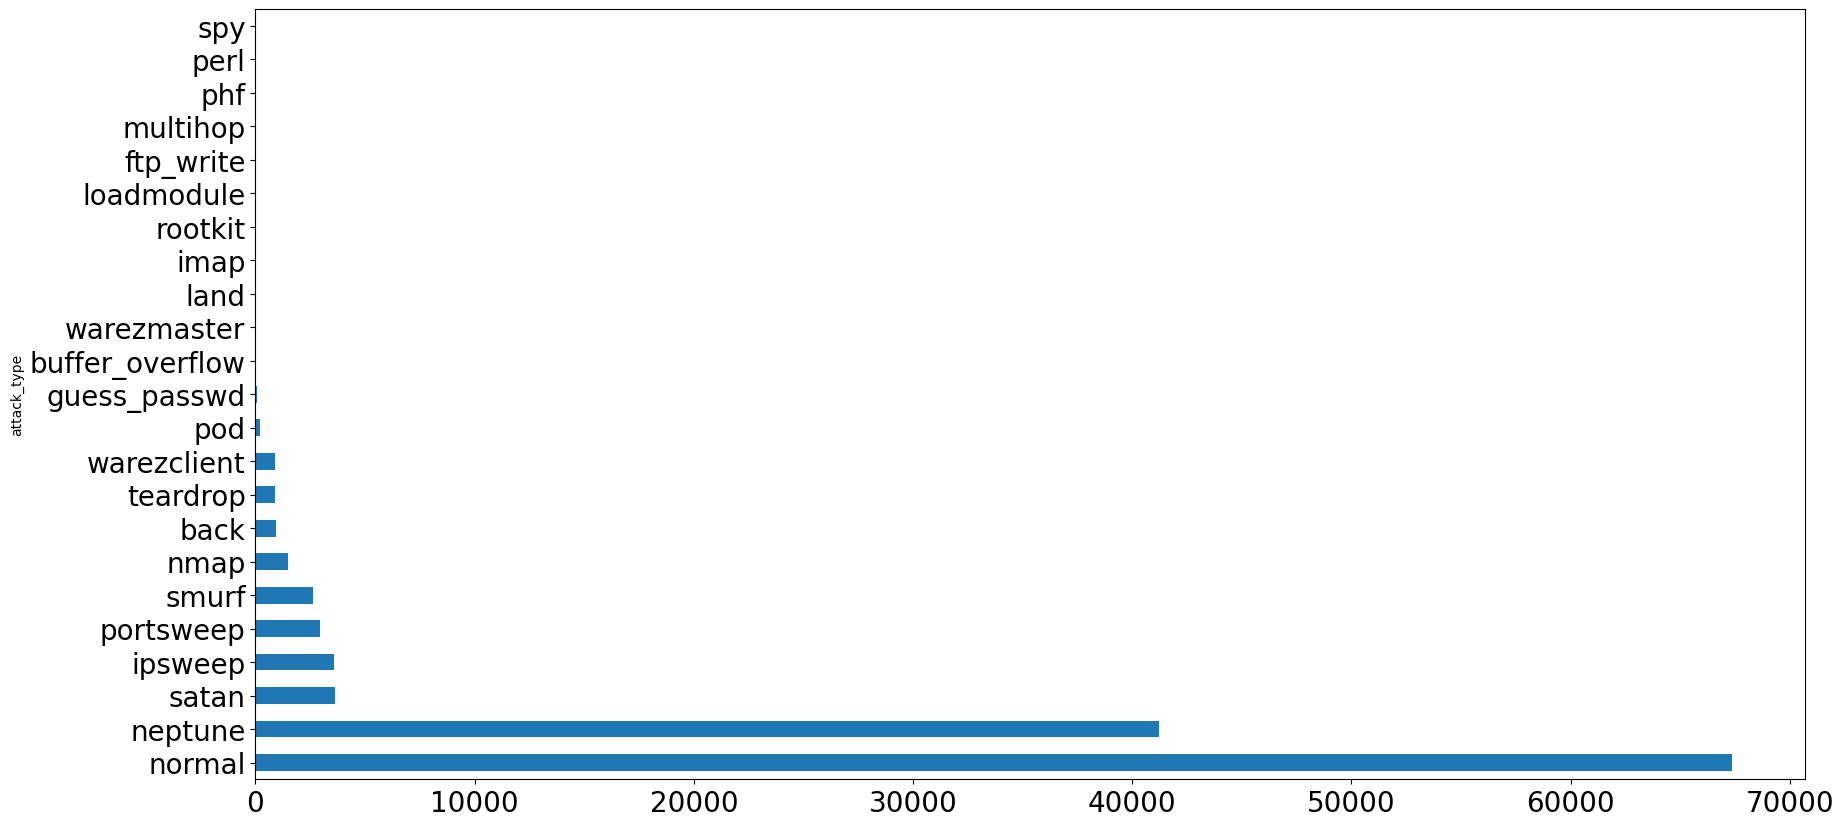

In [73]:
train_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=20)


<Axes: ylabel='attack_category'>

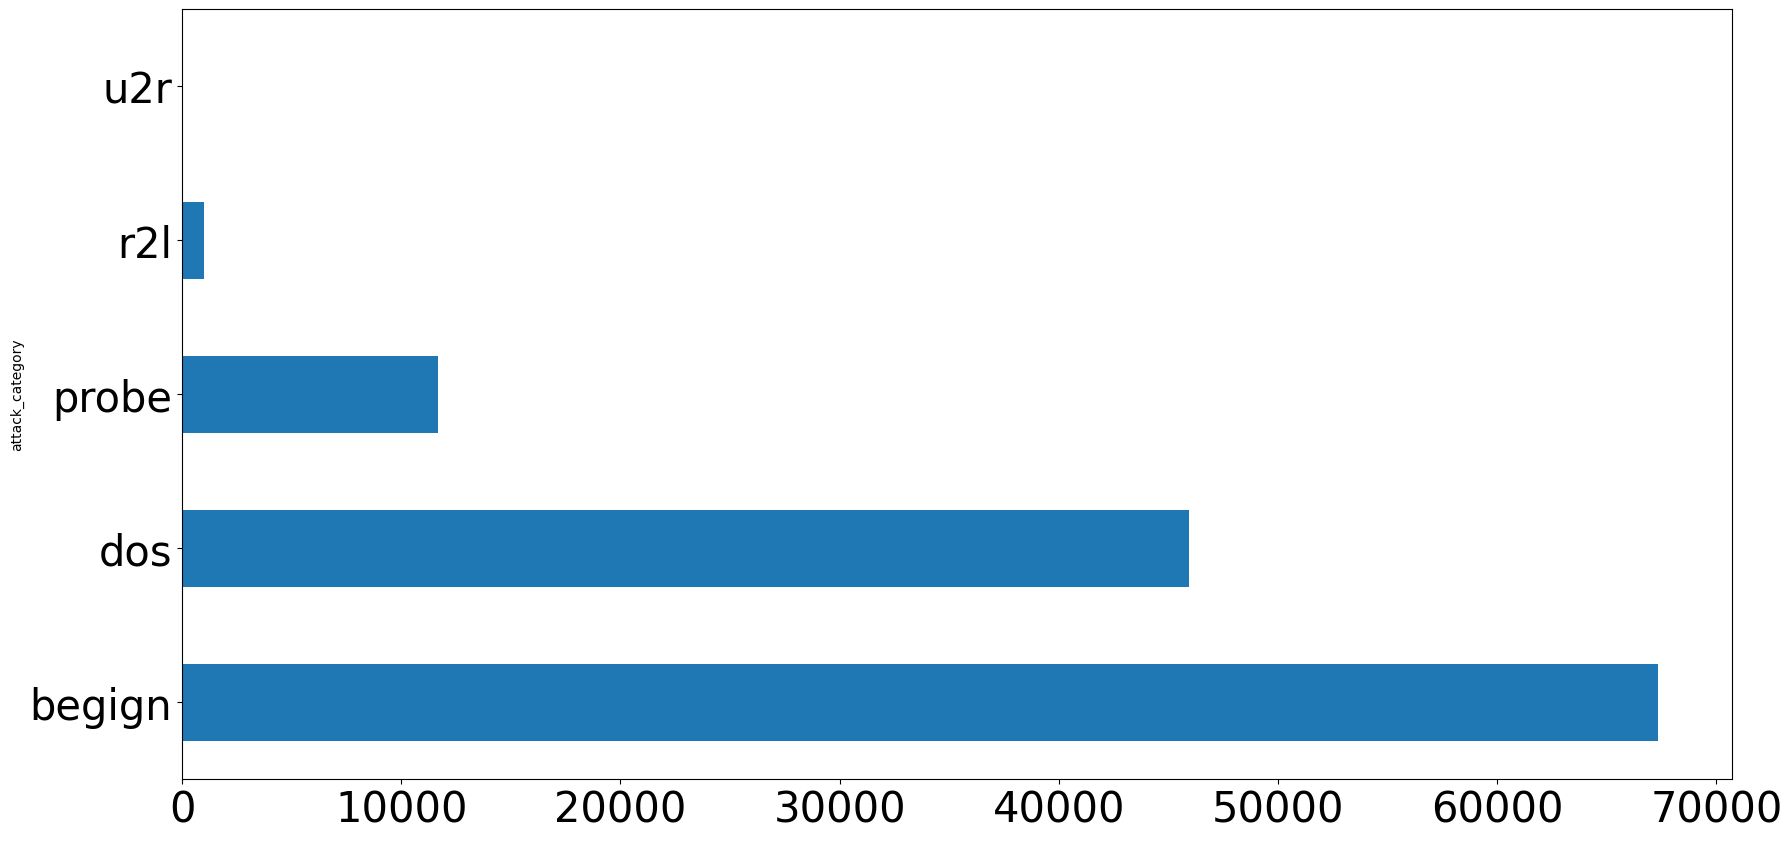

In [74]:
train_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

<Axes: ylabel='attack_type'>

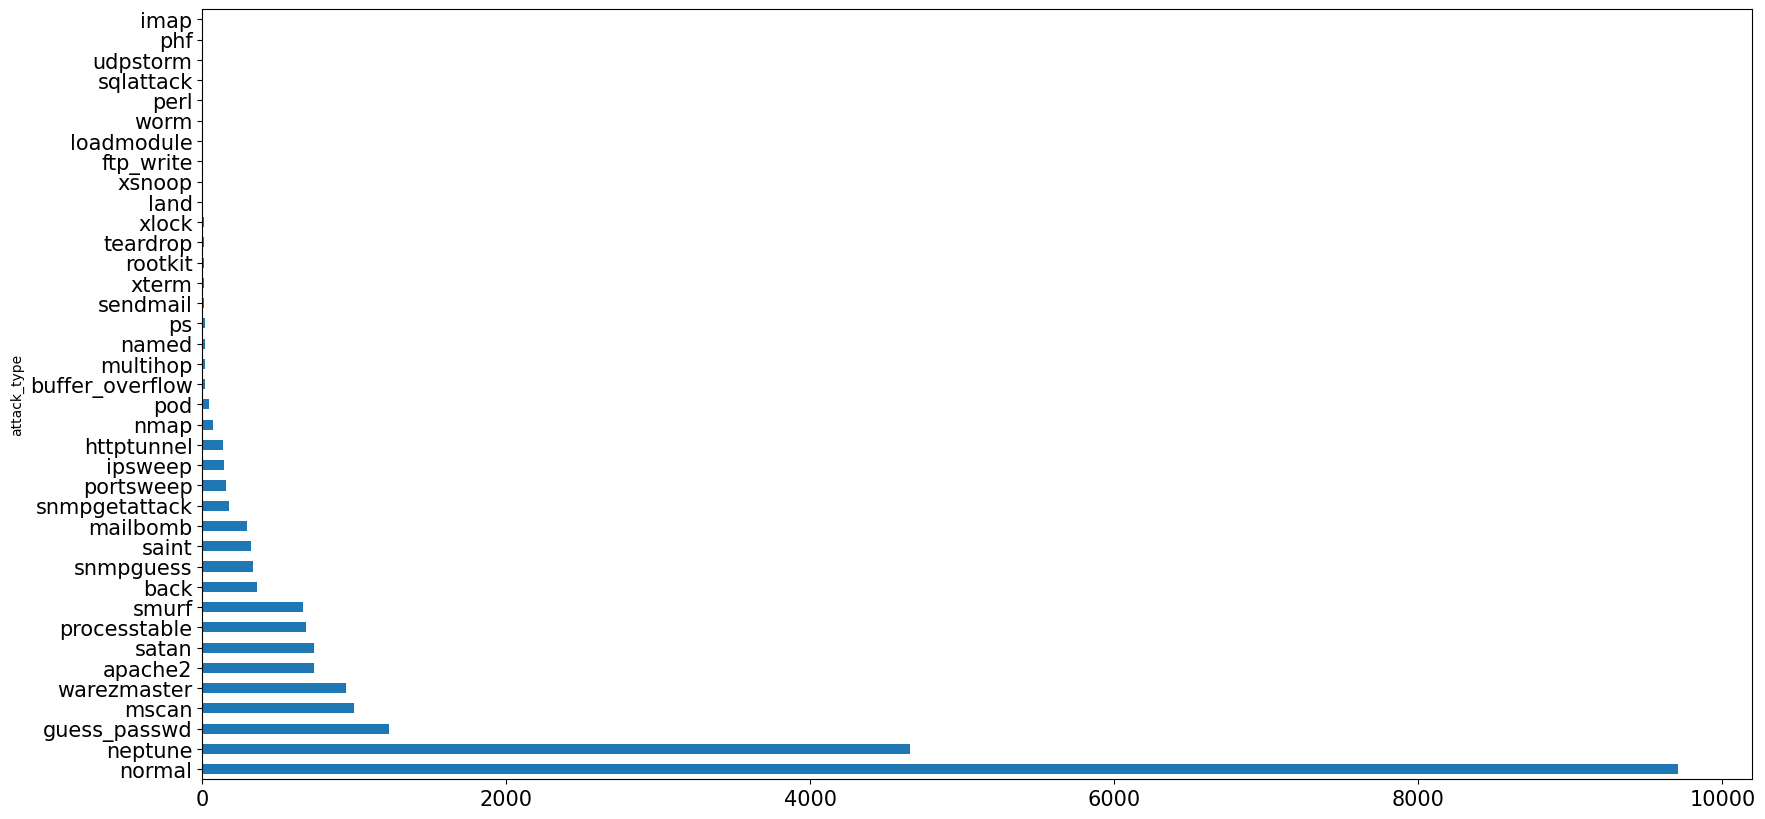

In [75]:
test_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=15)


<Axes: ylabel='attack_category'>

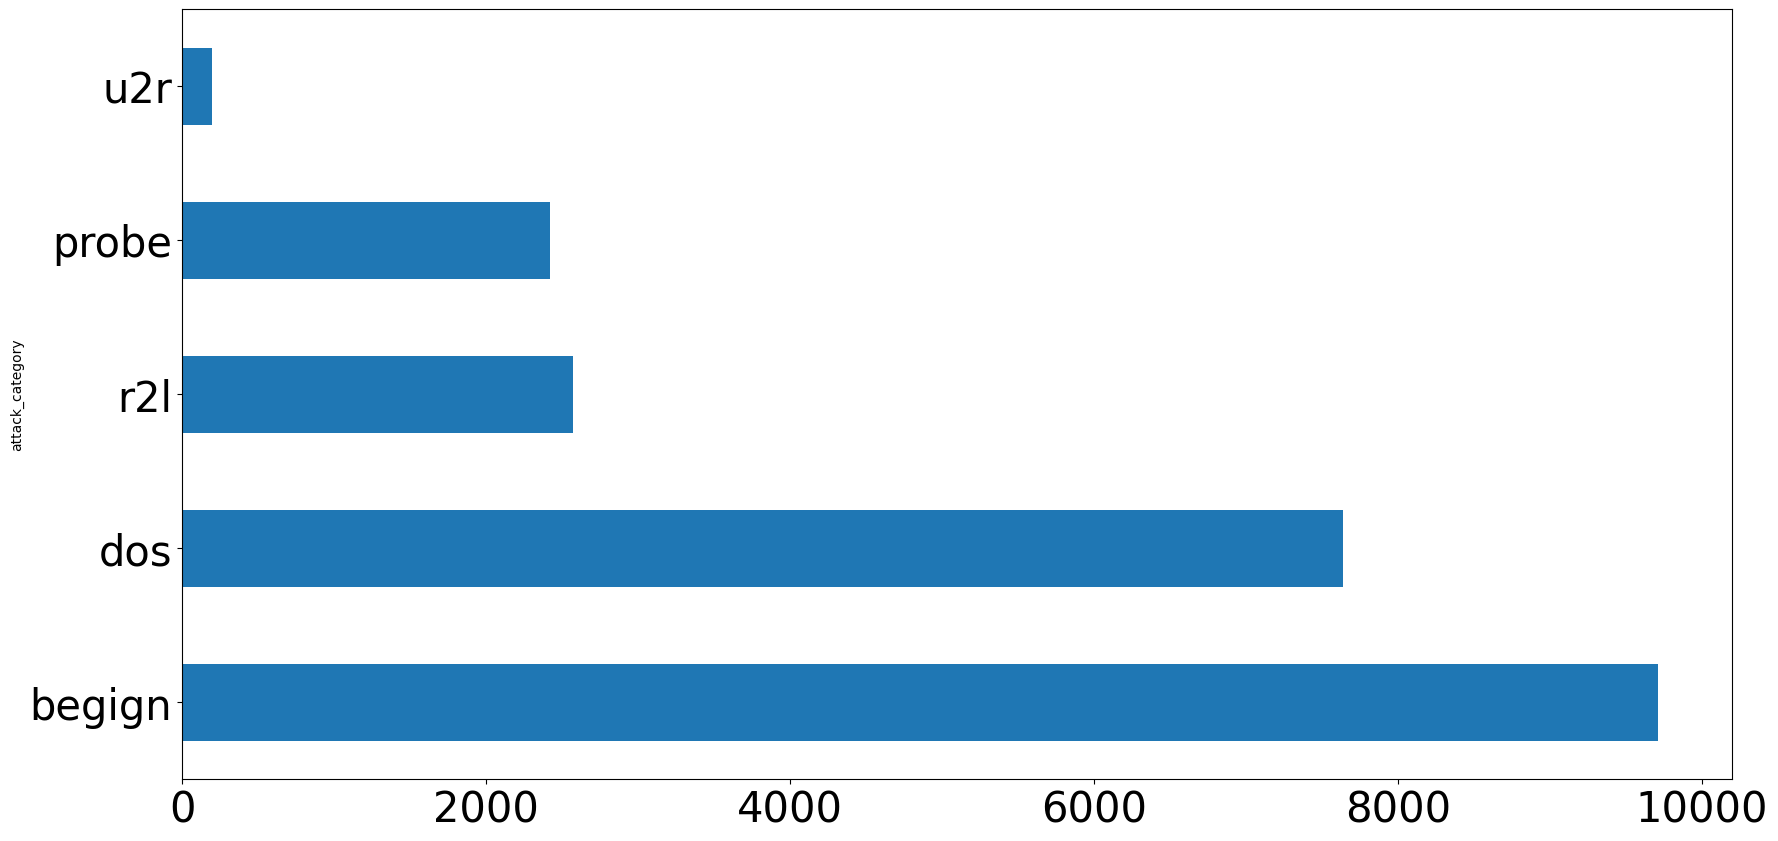

In [76]:
test_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

In [77]:
train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [78]:
train_df.groupby(['su_attempted']).size() #as binary features should have a min of 0.0 and a max of 1.0
# issue - the su_attempted column has a max value of 2.0

,0
su_attempted,
0,125893
1,21
2,59


In [79]:
#Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

,0
su_attempted,
0,125952
1,21


In [80]:
# Next, we notice that the num_outbound_cmds column only takes on one value! -> useless so dropping it

train_df.groupby(['num_outbound_cmds']).size()


,0
num_outbound_cmds,
0,125973


In [81]:
train_df.drop('num_outbound_cmds', axis=1, inplace=True)
test_df.drop('num_outbound_cmds', axis=1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

**Data Preparation**

In [82]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)


In [83]:
train_x_raw.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [84]:
'''# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=30)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs
'''

'# feature selection\ndef select_features(X_train, y_train, X_test):\n    fs = SelectKBest(score_func=mutual_info_classif, k=30)\n    fs.fit(X_train, y_train)\n    X_train_fs = fs.transform(X_train)\n    X_test_fs = fs.transform(X_test)\n    return X_train_fs, X_test_fs\n'

In [85]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

In [86]:
train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

In [87]:
# Store dummy variable feature names
dummy_variables = list(set(train_x) - set(combined_df_raw))

In [88]:
# execute the commands in console
train_x.describe()
train_x['duration'].describe()

,duration
count,125973.00000
mean,287.14465
std,2604.51531
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,42908.00000


In [89]:
#sanity check
# Experimenting with StandardScaler on the single 'duration' feature
durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()


,0
count,1.259730e+05
mean,2.549477e-17
std,1.000004e+00
min,-1.102492e-01
25%,-1.102492e-01
50%,-1.102492e-01
75%,-1.102492e-01
max,1.636428e+01


In [90]:
# Experimenting with MinMaxScaler on the single 'duration' feature

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()


,0
count,125973.000000
mean,0.006692
std,0.060700
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [91]:
# Experimenting with RobustScaler on the single 'duration' feature

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

,0
count,125973.00000
mean,287.14465
std,2604.51531
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,42908.00000


In [92]:
# Let's proceed with StandardScaler- Apply to all the numeric columns
'''StandardScaler is chosen because it's a safe, effective, and standard default.
  It satisfies the input requirements for the widest range of machine learning algorithms, making it a great general-purpose choice.
  While RobustScaler could also be a good option for this dataset (which is known to have outliers), StandardScaler is a more conventional starting point.
'''

"StandardScaler is chosen because it's a safe, effective, and standard default. \n  It satisfies the input requirements for the widest range of machine learning algorithms, making it a great general-purpose choice.\n  While RobustScaler could also be a good option for this dataset (which is known to have outliers), StandardScaler is a more conventional starting point.\n"

In [93]:
standard_scaler = StandardScaler().fit(train_x[numeric_cols])

In [94]:
train_x[numeric_cols] = standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = standard_scaler.transform(test_x[numeric_cols])

In [95]:
train_x.describe()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,...,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05
mean,2.549477e-17,-4.512349e-19,7.614590e-19,0.000198,4.230328e-19,4.455945e-18,-2.244894e-17,2.989431e-18,0.395736,-6.549957e-18,...,-1.756996e-17,-5.815290e-17,-1.215514e-16,-2.374624e-17,2.899184e-17,3.068398e-17,1.711873e-17,-2.631264e-17,4.907180e-17,7.749960e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,-1.836071e+00,-1.044721e+00,-1.161030e+00,-4.390782e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,-1.009507e+00,-9.543885e-01,-1.049659e+00,-4.390782e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,7.343426e-01,-4.756270e-01,-2.504011e-02,-3.332138e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,...,7.343426e-01,1.258754e+00,1.066401e+00,-6.855302e-02,-2.860195e-01,-1.114257e-01,1.608759e+00,1.618955e+00,-3.876346e-01,-3.763870e-01
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,...,7.343426e-01,1.258754e+00,1.066401e+00,4.854138e+00,2.756092e+00,8.594782e+00,1.608759e+00,1.618955e+00,2.874410e+00,2.753914e+00


In [130]:

print("*******************")
print("Data Exploration (Understanding the data)")
print("*******************")
print("1. Identify the attribute names (Header)")
print(train_df.columns)
print("2. Check the length of the Train and Test dataset")
print("length of Train dataset: ", train_df.size)
print("length of Test dataset: ", test_df.size)
print("3. Check the total number of samples that belong to each of the five classes of the training dataset.")
print(train_df.groupby('attack_category')['flag'].count())
print("*******************")


*******************
Data Exploration (Understanding the data)
*******************
1. Identify the attribute names (Header)
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
       'attack_category'],
      dtype='object')
2. Check the length of

In [96]:
# Decision Tree
def decision_tree_clf():
    print("------Decision Tree Classification-------")

    # build Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=17)

    # Train Classifier
    classifier.fit(train_x, train_Y)

    # predict
    pred_y = classifier.predict(test_x)

    # confusion matrix
    results = confusion_matrix(test_Y, pred_y)

    # error rate
    error = zero_one_loss(test_Y, pred_y)

    # print results
    print(results)
    print(error)

In [112]:
# random forest using hyperparameter tuning
def random_forest_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'n_estimators': [60],
        'criterion': ["gini"],
        'min_samples_split': [2, 4, 6, 10],
        'max_depth': [20, 25, 30],
        # 'max_leaf_nodes': [1, 5, 7, 10]
    }

    # random forest classifer
    clf = RandomForestClassifier()

    print("Searching for optimal parameters..............")

    # Building a 3 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=3)

    print("Training the data...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print(rf_best)

    print(grid_object.best_score_)

In [113]:
# Random Forest
def random_forest_clf():
    print(colored("------Random Forest Classification-------", 'red'))
    # build classifier
    clf = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=48, random_state=0)

    # start timer
    start_time = timeit.default_timer()

    print("Training the Random Forest Classifier.......")

    clf = clf.fit(train_x, train_Y)

    # end timer
    print("The time difference is :", timeit.default_timer() - start_time)

    print("Predicting test data.......")

    '''features = clf.feature_importances_
    feature_cols = []
    # print feature importance
    for i, j in enumerate(features, 1):
        if j <= 0.0:
            feature_cols.append(i)
            print(i)
    new_train_x = train_x.copy()
    new_test_x = test_x.copy()

    for k in feature_cols:
        new_train_x.drop(new_train_x.columns[k], axis=1, inplace=True)
        new_test_x.drop(new_test_x.columns[k], axis=1, inplace=True)

    clf2 = RandomForestClassifier(n_estimators=240, random_state=0)
    clf2 = clf2.fit(new_train_x, train_Y)'''

    # predict test data
    pred_y = clf.predict(test_x)

    # analyse prediction
    c_matrix = confusion_matrix(test_Y, pred_y)  # confusion matrix
    error = zero_one_loss(test_Y, pred_y)  # error
    score = accuracy_score(test_Y, pred_y)  # accuracy score

    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(clf, test_x, test_Y)
    plt.title("Confusion Matrix for Random Forest")
    plt.show()

In [117]:
# KNN classifier
def knn_clf():
    print(colored("------KNN Classification-------", 'red'))

    # KNN classifier
    clf_knn = KNeighborsClassifier(n_neighbors=7)  # using 7 because it has higher accuray rate

    # start timer
    starttime = timeit.default_timer()

    print("Training the KNN Classifier.......")

    # Train model
    clf_knn = clf_knn.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_knn.predict(test_x)

    # analyse results
    c_matrix = confusion_matrix(test_Y, pred_y)  # confusion matrix
    error = zero_one_loss(test_Y, pred_y)  # error
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_knn, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f'
    )
    plt.title("Confusion Matrix for k-nearest neighbors")

    plt.show()

In [114]:
# SVM classification
def svc_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'gamma': ['scale', 'auto']
    }

    # SVC estimator
    clf = SVC(random_state=0)

    print("Searching for optimal parameters..............")

    # Building a 3 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=10)

    print("Training the data...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print("Best Parameters are:\n", rf_best)

In [120]:
# SVC
def svm_clf():
    print(colored("------SVM Classification-------", 'red'))
    # build classifier
    clf_svc = SVC(kernel='poly', degree=1, C=3)  # using poly for kernel -> change and check with RBF and poly of higher degrees

    # start timer
    starttime = timeit.default_timer()

    print("Training the SVM Classifier.......")

    # train SVC
    clf_svc = clf_svc.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_svc.predict(test_x)

    # anlayse results
    c_matrix = confusion_matrix(test_Y, pred_y)
    error = zero_one_loss(test_Y, pred_y)
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_svc, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f'
    )
    plt.title("Confusion Matrix for SVM")

    plt.show()

In [123]:
# Multi-Layer Percepton MLP
def mlp_clf():
    print(colored("------MLP Classification-------", 'red'))

    # Build classifier
    clf_nn = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1000, 5), max_iter=1000, random_state=1)

    print("Training the MLP Classifier.......")

    # start timer
    starttime = timeit.default_timer()  # start timer

    # train
    clf_nn.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    nn_pred = clf_nn.predict(test_x)

    # results
    c_matrix = confusion_matrix(test_Y, nn_pred)
    error = zero_one_loss(test_Y, nn_pred)
    score = accuracy_score(test_Y, nn_pred)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, nn_pred))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_nn, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f'
    )
    plt.title("Confusion Matrix for Neural Network")

    plt.show()

In [124]:
# Xgboost grid search -> hyperparameter tuning
def xgboost_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {"learning_rate": [0.05, 0.10, 0.2, 0.3],
                   "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                   "n_estimators": [50, 100, 200, 250, 500]
                   }

    # Adaboost classifier
    clf = xgb.XGBClassifier()

    print("Searching for optimal parameters..............")

    # Building a 10 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=5, scoring='accuracy', n_jobs=-1)

    print("Training the model...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model=
    rf_best = grid_object.best_estimator_
    print(rf_best)

    print('Best score : ', grid_object.best_score_)


In [139]:
#XgBoost classifier
def xgboost_clf():
    print(colored("------XGBoost Classification-------", 'red'))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    train_Y_encoded = le.fit_transform(train_Y)
    test_Y_encoded = le.transform(test_Y)

    num_classes = len(np.unique(train_Y_encoded))

    xgb_model = xgb.XGBClassifier(
        base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=1,
        learning_rate=0.2, max_delta_step=0, max_depth=3,
        min_child_weight=1, n_estimators=490, n_jobs=-1,
        objective='multi:softprob', num_class=num_classes,
        random_state=0, reg_alpha=0, reg_lambda=1,
        scale_pos_weight=1, subsample=1, verbosity=1
    )

    print("Training the XGBoost Classifier.......")
    starttime = timeit.default_timer()
    xgb_model.fit(train_x, train_Y_encoded)
    print("Training time: {:.2f} seconds".format(timeit.default_timer() - starttime))

    print("Predicting test data.......")
    xgb_pred_encoded = xgb_model.predict(test_x)

    c_matrix = confusion_matrix(test_Y_encoded, xgb_pred_encoded)
    error = zero_one_loss(test_Y_encoded, xgb_pred_encoded)
    score = accuracy_score(test_Y_encoded, xgb_pred_encoded)

    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y_encoded, xgb_pred_encoded))
    print('accuracy per class: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    disp = ConfusionMatrixDisplay.from_estimator(
        xgb_model, test_x, test_Y_encoded, cmap=plt.cm.Greens, values_format='.0f'
    )
    plt.title("Confusion Matrix for XGBoost")
    plt.show()

In [128]:
 #decision tree classifier
decision_tree_clf()




------Decision Tree Classification-------
[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
0.2378903477643719


------Random Forest Classification-------
Training the Random Forest Classifier.......
The time difference is : 7.703228337999917
Predicting test data.......
Confusion Matrix
---------------------------
 [[9459   67  184    0    1]
 [1350 6250   36    0    0]
 [ 772  166 1485    0    0]
 [2460    0    2  110    2]
 [ 192    0    1    4    3]]
---------------------------
Error: 23.2301%
Accuracy Score: 76.7699%
              precision    recall  f1-score   support

      begign       0.66      0.97      0.79      9711
         dos       0.96      0.82      0.89      7636
       probe       0.87      0.61      0.72      2423
         r2l       0.96      0.04      0.08      2574
         u2r       0.50      0.01      0.03       200

    accuracy                           0.77     22544
   macro avg       0.79      0.49      0.50     22544
weighted avg       0.82      0.77      0.73     22544

accuracy:  [0.97405005 0.81849136 0.6128766  0.04273504 0.015     ]


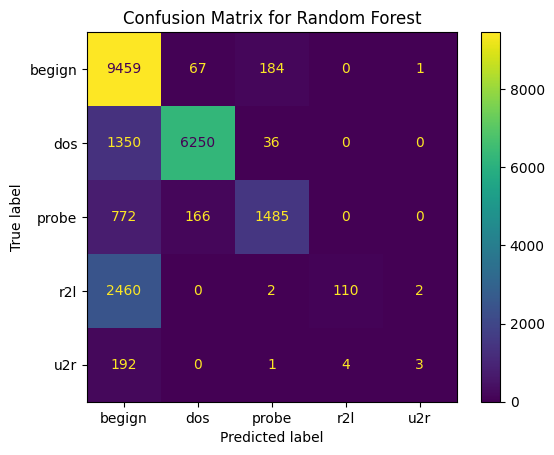

In [131]:
#random forest classifier
random_forest_clf()


------KNN Classification-------
Training the KNN Classifier.......
The time difference is : 0.9552149460000692
Predicting test data.......
Confusion Matrix
---------------------------
 [[9443   55  210    2    1]
 [1610 5937   89    0    0]
 [ 595  180 1648    0    0]
 [2347    2   53  171    1]
 [ 105    0   85    4    6]]
---------------------------
Error: 23.6826%
Accuracy Score: 76.3174%
              precision    recall  f1-score   support

      begign       0.67      0.97      0.79      9711
         dos       0.96      0.78      0.86      7636
       probe       0.79      0.68      0.73      2423
         r2l       0.97      0.07      0.12      2574
         u2r       0.75      0.03      0.06       200

    accuracy                           0.76     22544
   macro avg       0.83      0.51      0.51     22544
weighted avg       0.82      0.76      0.73     22544

accuracy:  [0.97240243 0.77750131 0.68014858 0.06643357 0.03      ]


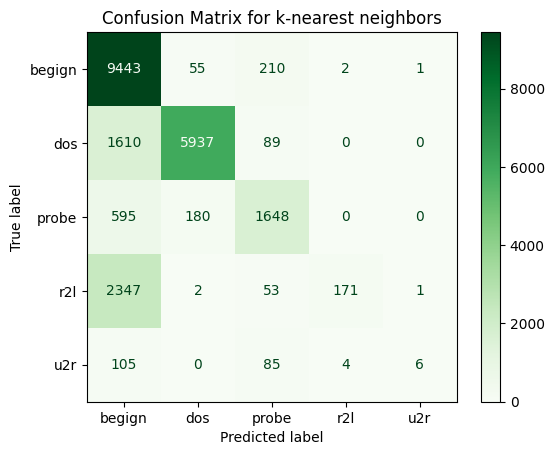

In [132]:
#KNN classifier
knn_clf()


------SVM Classification-------
Training the SVM Classifier.......
The time difference is : 157.27803048499982
Predicting test data.......
Confusion Matrix
---------------------------
 [[9112  423  168    7    1]
 [1511 6112   13    0    0]
 [ 733  112 1578    0    0]
 [2299    4    2  269    0]
 [ 191    0    0    4    5]]
---------------------------
Error: 24.2548%
Accuracy Score: 75.7452%
              precision    recall  f1-score   support

      begign       0.66      0.94      0.77      9711
         dos       0.92      0.80      0.86      7636
       probe       0.90      0.65      0.75      2423
         r2l       0.96      0.10      0.19      2574
         u2r       0.83      0.03      0.05       200

    accuracy                           0.76     22544
   macro avg       0.85      0.50      0.52     22544
weighted avg       0.81      0.76      0.73     22544

accuracy:  [0.93831737 0.80041907 0.65125877 0.1045066  0.025     ]


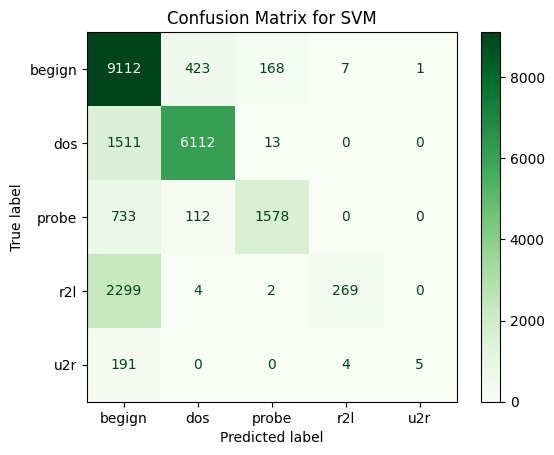

In [133]:
#SVM classifier
svm_clf()


------MLP Classification-------
Training the MLP Classifier.......
The time difference is : 123.46473007699979
Predicting test data.......
Confusion Matrix
---------------------------
 [[9234  213  262    2    0]
 [1129 6478   29    0    0]
 [ 620  257 1546    0    0]
 [1807    0  483  284    0]
 [ 151    0   43    6    0]]
---------------------------
Error: 22.1877%
Accuracy Score: 77.8123%
              precision    recall  f1-score   support

      begign       0.71      0.95      0.82      9711
         dos       0.93      0.85      0.89      7636
       probe       0.65      0.64      0.65      2423
         r2l       0.97      0.11      0.20      2574
         u2r       0.00      0.00      0.00       200

    accuracy                           0.78     22544
   macro avg       0.65      0.51      0.51     22544
weighted avg       0.80      0.78      0.74     22544

accuracy:  [0.95088044 0.84834992 0.638052   0.11033411 0.        ]


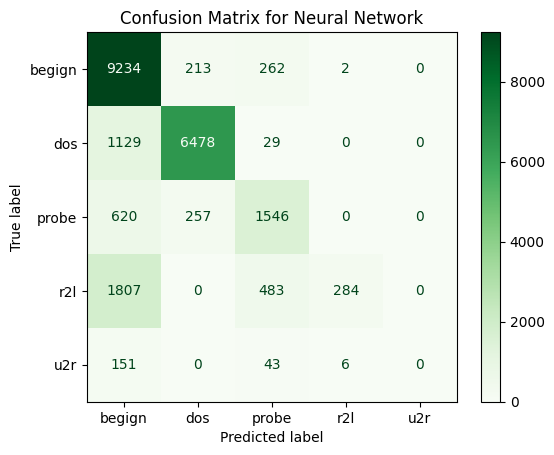

In [134]:
#Neural Network classifier
mlp_clf()


------XGBoost Classification-------
Training the XGBoost Classifier.......
Training time: 75.56 seconds
Predicting test data.......
Confusion Matrix
---------------------------
 [[9441   75  194    0    1]
 [1564 6022   50    0    0]
 [ 740  163 1476   44    0]
 [2276    0    3  292    3]
 [ 187    0    2    2    9]]
---------------------------
Error: 23.5273%
Accuracy Score: 76.4727%
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.96      0.79      0.87      7636
           2       0.86      0.61      0.71      2423
           3       0.86      0.11      0.20      2574
           4       0.69      0.04      0.08       200

    accuracy                           0.76     22544
   macro avg       0.81      0.51      0.53     22544
weighted avg       0.81      0.76      0.73     22544

accuracy per class:  [0.97219648 0.78863279 0.6091622  0.11344211 0.045     ]


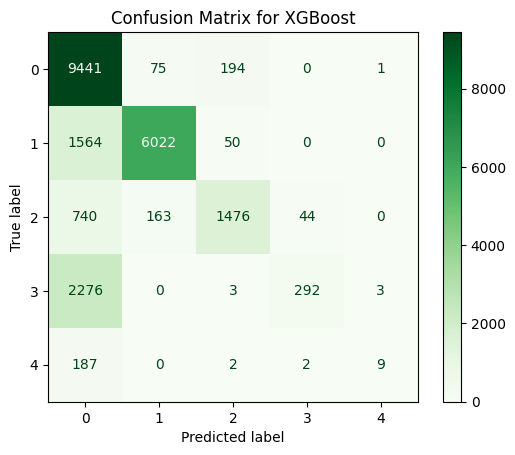

In [141]:
#XgBoost classifier
xgboost_clf()